In [5]:
pip install torch --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 735.4 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 52.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0
    Uninstalling torch-1.13.0:
      Successfully uninstalled torch-1.13.0
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install torchvision --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 39.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0
    Uninstalling torchvision-0.14.0:
      Successfully uninstalled torchvision-0.14.0
Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms, models 

# Define the path to the Flowers dataset on Kaggle
data_path = "/kaggle/input/flowers/flowers/"

# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the dataset
dataset = ImageFolder(data_path, transform=transform)

# Create the data loader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)


In [21]:
class VGG16(nn.Module):
    def __init__(self, num_classes=5):
        super(VGG16, self).__init__()
        self.features = models.vgg16(pretrained=False).features
        self.classifier = nn.Linear(512 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [22]:
my_gpu = torch.cuda.is_available()
print(f'Train on gpu: {my_gpu}')
device = torch.device('cuda' if my_gpu else 'cpu')

Train on gpu: True


In [23]:
model = VGG16(num_classes = 16).to(device)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [24]:
best_checkpoint = torch.load('/kaggle/input/d3-vgg/d3_vgg16_model_checkpoint.pth')
print(best_checkpoint.keys())
model.load_state_dict(best_checkpoint['state_dict'])


dict_keys(['epoch', 'state_dict', 'optimizer', 'train_loss', 'val_loss'])


<All keys matched successfully>

In [25]:
# Extract the features for each batch of images
features = []
model.eval()


VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [26]:
with torch.no_grad():
    for images, _ in dataloader:
        images = images.to('cuda')
        feats = model(images)
        features.append(feats.cpu().detach().numpy())



In [27]:
# Convert the features to a 2D array using t-SNE
features = np.concatenate(features, axis=0)
tsne = TSNE(n_components=3, perplexity=50, learning_rate=200, random_state=123)
embeddings = tsne.fit_transform(features)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


In [10]:
unique_targets = torch.unique(torch.tensor(dataset.targets))
print("Unique targets:", unique_targets)

Unique targets: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])


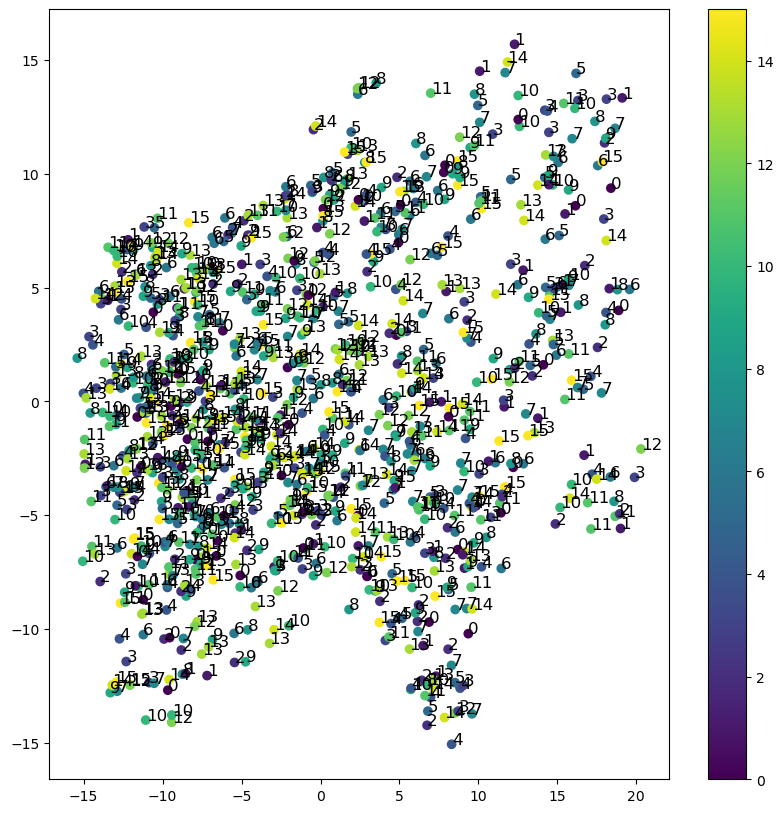

In [70]:
import numpy as np

# randomly select 1000 embeddings
indices = np.random.choice(len(embeddings), size=1000, replace=False)
subset_embeddings = embeddings[indices]
subset_targets = np.array(dataset.targets)[indices]

# plot the subset of embeddings
plt.figure(figsize=(10, 10))
plt.scatter(subset_embeddings[:, 0], subset_embeddings[:, 1], c=subset_targets, cmap='viridis')
for i, txt in enumerate(subset_targets):
    plt.text(subset_embeddings[i, 0], subset_embeddings[i, 1], str(txt), fontsize=12)
plt.colorbar()
plt.show()


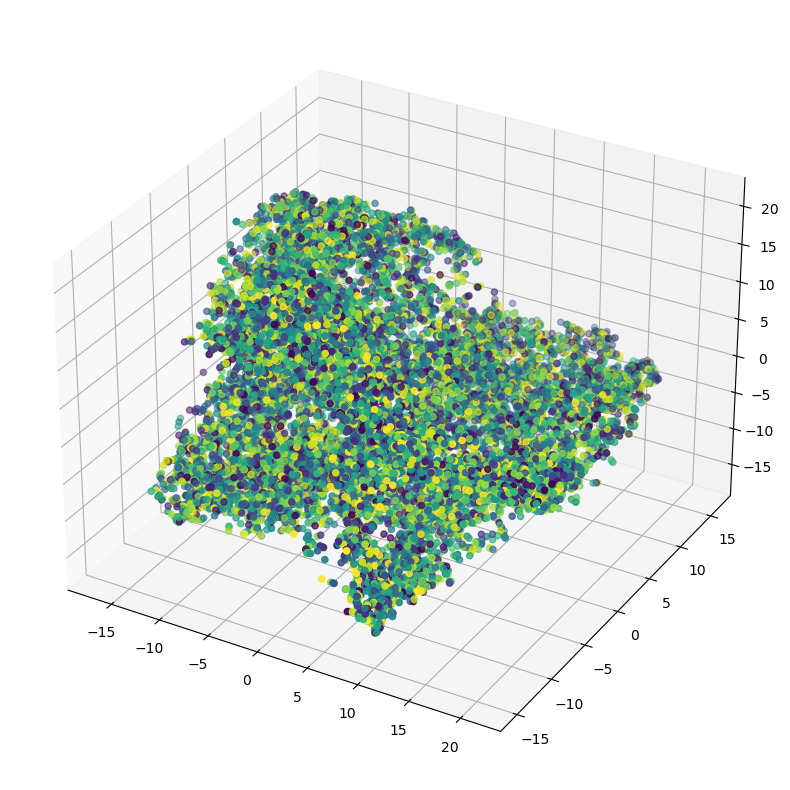

In [36]:
# Plot the embeddings
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=dataset.targets)
plt.show()


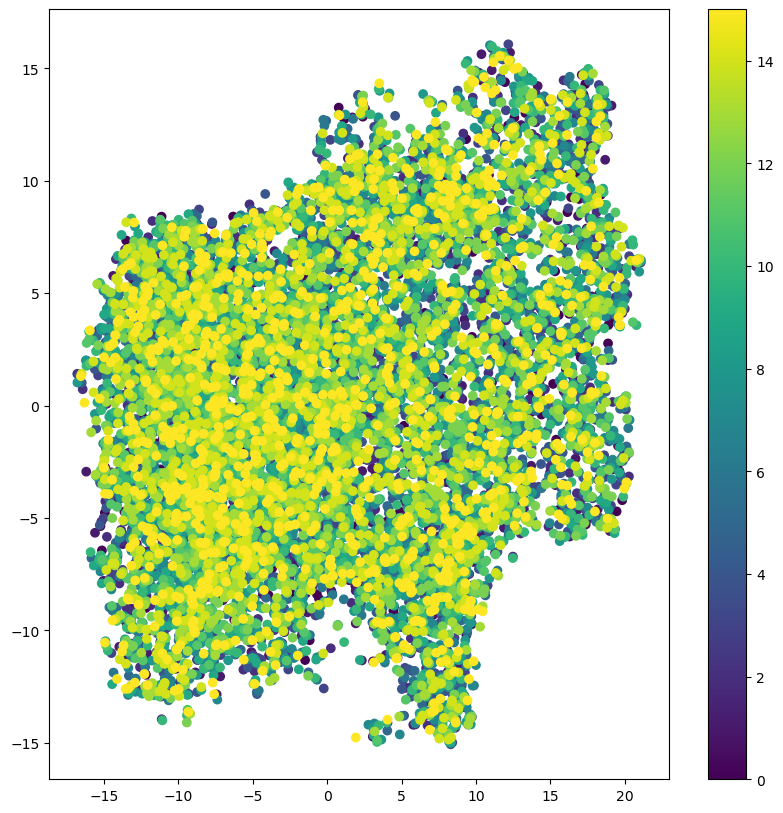

In [37]:
# Plot the embeddings
plt.figure(figsize=(10, 10))

plt.scatter(embeddings[:, 0], embeddings[:, 1], c=dataset.targets, cmap='viridis')
plt.colorbar()
plt.show()

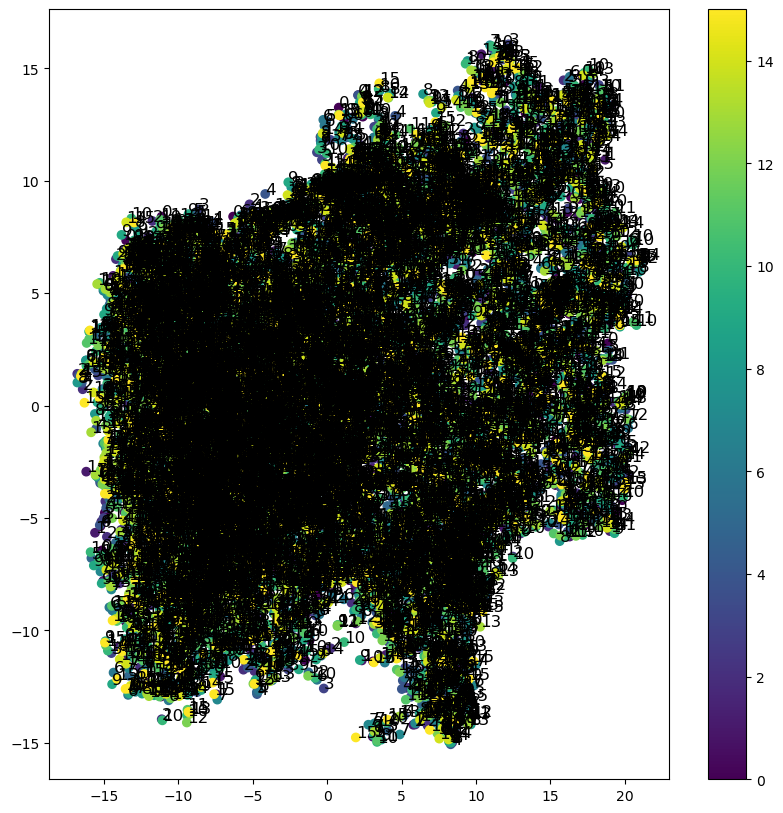

In [38]:
# Plot the embeddings
plt.figure(figsize=(10, 10))

plt.scatter(embeddings[:, 0], embeddings[:, 1], c=dataset.targets, cmap='viridis')

# Add text labels for each point
for i, txt in enumerate(dataset.targets):
    plt.text(embeddings[i, 0], embeddings[i, 1], str(txt), fontsize=12)

plt.colorbar()
plt.show()


In [55]:
len(subset_targets)

2000

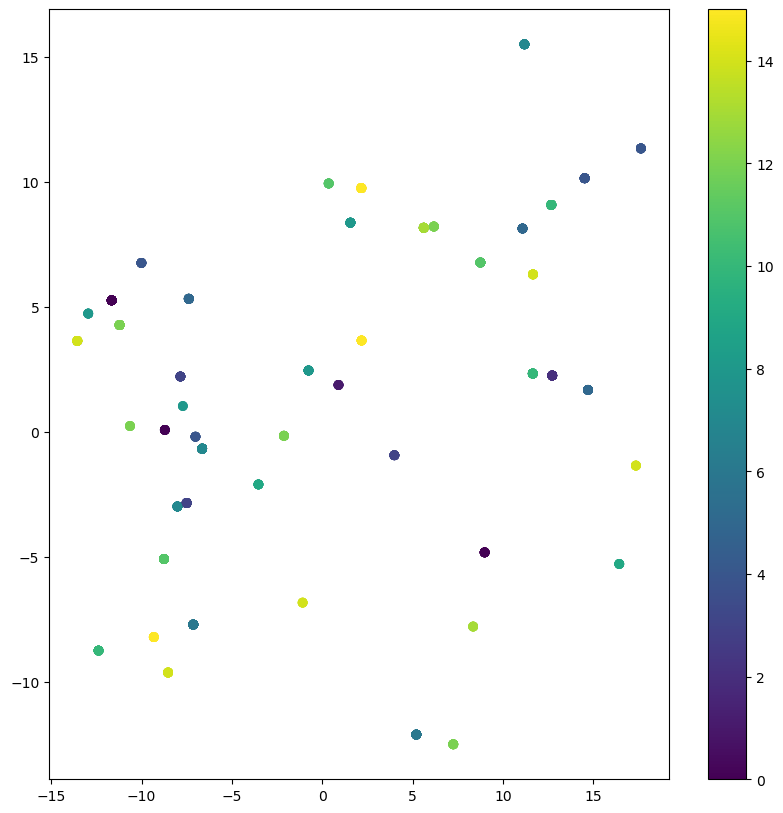

In [64]:
import numpy as np

# Select a random subset of embeddings to plot
N =  1000   # Number of points to plot
indices = np.random.choice(indices, size=N, replace=False)

subset_embeddings = embeddings[indices]
subset_targets = []

for idx in indices:
    subset_targets.append(dataset.targets[idx])

# Plot the embeddings with targets as labels
plt.figure(figsize=(10, 10))
plt.scatter(subset_embeddings[:, 0], subset_embeddings[:, 1], c=subset_targets, cmap='viridis')
plt.colorbar()
plt.show()
